In [1]:
# add additional processes to serve as workers 
n_procs = 3
addprocs(n_procs);  

In [2]:
# add present working directory to path from which to load modules
push!(LOAD_PATH, ".") 

# load module DynamicProgramming on each of the processes 
using DynamicProgramming
using Interpolations

In [3]:
# model parameters

N = 25 # horizon

# vehicle 1
@everywhere L1 = 1.       # car length (determines turning radius)
@everywhere V_max1 = 0.1  # maximum velocity 
@everywhere S_max1 = 1.   # maximum steering angle 
# vehicle 2
@everywhere L2 = 1.
@everywhere V_max2 = 0.1
@everywhere S_max2 = 1. 
# vector of parameters
theta0 = [L1; V_max1; S_max1; L2; V_max2; S_max2]

# initial state
# x0 = [0.; 0.; 0.; -0.5; 0.; 0]

# dynamics
@everywhere function f(k::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    z1, y1, th1, z2, y2, th2 = x
    v1, s1, v2, s2 = u
    L1, V_max1, S_max1, L2, V_max2, S_max2 = theta
    x_plus = [z1 + V_max1*v1*cos(th1); y1 + V_max1*v1*sin(th1); mod2pi(th1 + 1/L1*V_max1*v1*tan(S_max1*s1)); z2 + V_max2*v2*cos(th2); y2 + V_max2*v2*sin(th2); mod2pi(th2 + 1/L2*V_max2*v2*tan(S_max2*s2))]
    return x_plus
end

# test dynamics 
# f(0, x0, [1., 0., 1., -1.], theta0)

# reward function 

@everywhere function potential(r)
    return abs(r-1)
end

@everywhere function g(k::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    #r = sqrt((x[1] - x[4])^2 + (x[2] - x[5])^2)
    #return -(x[3] - x[6])^2 - potential(r)
    return 0.
end

@everywhere function g_terminal(x::Array{Float64, 1})
    r = sqrt((x[1] - x[4])^2 + (x[2] - x[5])^2)
    return -(x[3] - x[6])^2 - potential(r)
end

# test reward function 
# g(0, x0, [1., 0., 1., -1.], theta0)

# define input grid
@everywhere nu1 = 2
@everywhere nu2 = 3
@everywhere nu3 = 2
@everywhere nu4 = 3
@everywhere ugrid = (
                     linspace( 0, 1, nu1), 
                     linspace(-1, 1, nu2), 
                     linspace( 0, 1, nu3), 
                     linspace(-1, 1, nu4) 
                    ) 

# define state grid 
@everywhere nx1 = 51 # number of grid points in each dimension  
@everywhere nx2 = 51
@everywhere nx3 = 65
@everywhere xgrid_reduced = (
                     linspace(-1.5, 1.5, nx1), 
                     linspace(-1.5, 1.5, nx2), 
                     linspace(0, 2pi, nx3)
                    ) 

In [4]:
# define invariants 

@everywhere function rho(x::Array{Float64, 1})
    return [(x[4] - x[1])*cos(x[3]) + (x[5] - x[2])*sin(x[3]);
           -(x[4] - x[1])*sin(x[3]) + (x[5] - x[2])*cos(x[3]);
            mod2pi(x[6] - x[3])
        ]
end

@everywhere function rho_bar_inverse(x_bar::Array{Float64, 1})
    return [0; 0; 0; x_bar]
end


In [5]:
# Lets do this
# @time J = dp_reduced(f, g, g_terminal, rho, rho_bar_inverse, ugrid, xgrid_reduced, theta0, N);

# reload value function 
using HDF5, JLD
J = load("J_Dubins_cooperative.jld")["data"]; 

In [25]:
# compute a policy rollout from initial state x0

x0 = [-0.1; 0.; 0.5*pi; 0.1; 0.; 1.5*pi]
x_opt, u_opt = DynamicProgramming.dp_rollout_reduced_stochastic(J, x0, f, g, rho, ugrid, xgrid_reduced, theta0, N, 0.3)
x_opt

6×26 Array{Float64,2}:
 -0.1      -0.1      -0.130179  -0.119743  …   1.37959    1.47467    1.47467 
  0.0       0.1       0.195337   0.294791      0.187817   0.156832   0.156832
  1.5708    1.87736   1.46624    1.07394       5.96815    5.48113    5.60449 
  0.1       0.1       0.1        0.1           1.02639    1.11489    1.19179 
  0.0      -0.1      -0.1       -0.1          -0.711208  -0.757767  -0.821689
  4.71239   5.11896   4.95433    4.90272   …   5.79888    5.58971    5.24116 

In [26]:
using Colors 
using Gadfly

berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
berkeley_gold = RGB((1/256*[224., 158.,  25.])...); 
gray          = RGB((1/256*[200., 200., 200.])...); 
black         = RGB((1/256*[0., 0., 0.])...); 

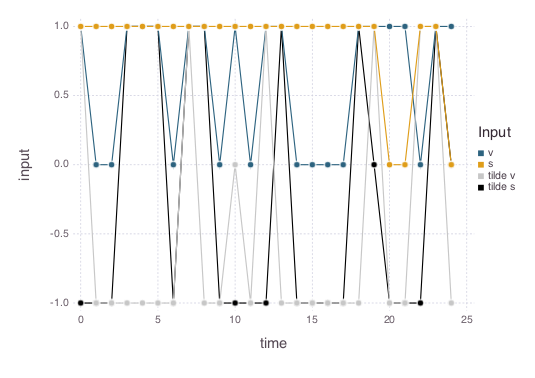

In [27]:
# plot optimal input 

p = Gadfly.plot(layer(x=0:N-1, y=u_opt[1, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
layer(x=0:N-1, y=u_opt[2, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        layer(x=0:N-1, y=u_opt[3, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N-1, y=u_opt[4, :], Geom.point, Geom.line, Theme(default_color=black)), 
        Guide.XLabel("time"), 
        Guide.YLabel("input"),
Guide.manual_color_key("Input", ["v", "s", "tilde v", "tilde s"], [berkeley_blue, berkeley_gold, gray, black])
)
draw(PDF("Dubins_cooperative_input_stochastic.pdf", 15cm, 10cm), p)
p

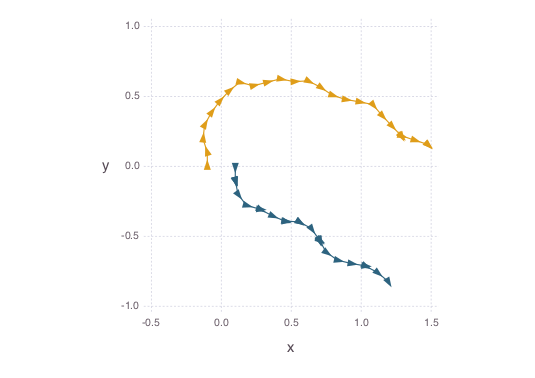

In [28]:
## Code for plotting Dubins vehicle state with triangle to show orientation

using Compose

function marker(x, y, angle, color, markersize)
    R = [cos(angle -pi/2) -sin(angle-pi/2);
         sin(angle-pi/2)  cos(angle-pi/2)]
    p1 = R*[-markersize/2; -markersize/2]
    p2 = R*[markersize/2; -markersize/2]
    p3 = R*[0; markersize]
    return compose(context(),
                  polygon([(x + p1[1], y + p1[2]),
                           (x + p2[1], y + p2[2]),
                           (x + p3[1], y + p3[2])]),
                  fill(color)
    )
end

triangles_v1 = Array(Any, N+1)
triangles_v2 = Array(Any, N+1)
for k=1:N+1
    triangles_v1[k] = Guide.annotation(marker(x_opt[1, k], x_opt[2, k], x_opt[3, k], berkeley_gold, 0.05))
    triangles_v2[k] = Guide.annotation(marker(x_opt[4, k], x_opt[5, k], x_opt[6, k], berkeley_blue, 0.05))
end

p = Gadfly.plot(layer(x=x_opt[1, :], y=x_opt[2, :], Geom.path, Theme(default_color=berkeley_gold)),
  layer(x=x_opt[4, :], y=x_opt[5, :], Geom.path, Theme(default_color=berkeley_blue)),
  triangles_v1...,
  triangles_v2...,
  Coord.cartesian(fixed=true)
)
draw(PDF("Dubins_cooperative_state_stochastic.pdf", 10cm, 20cm), p)
p

In [10]:
# compare against deterministic solution 

x0 = [-0.1; 0.; 0.5*pi; 0.1; 0.; 1.5*pi]
x_opt, u_opt = DynamicProgramming.dp_rollout_reduced_stochastic(J, x0, f, g, rho, ugrid, xgrid_reduced, theta0, N, 0.0)
x_opt

6×26 Array{Float64,2}:
 -0.1      -0.1      -0.115511   …  -1.36124   -1.36124   -1.36124 
  0.0       0.1       0.19879        0.56179    0.56179    0.56179 
  1.5708    1.72654   1.88228        2.97246    2.97246    2.97246 
  0.1       0.1       0.0844888     -1.3287    -1.3287    -1.3287  
  0.0      -0.1      -0.19879       -0.429988  -0.429988  -0.429988
  4.71239   4.55665   4.40091    …   2.99924    2.99924    2.99924 

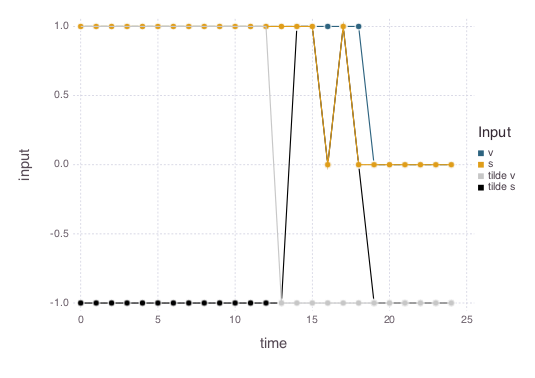

In [11]:
# plot optimal input 

p = Gadfly.plot(layer(x=0:N-1, y=u_opt[1, :], Geom.point, Geom.line, Theme(default_color=berkeley_gold)), 
layer(x=0:N-1, y=u_opt[2, :], Geom.point, Geom.line, Theme(default_color=gray)), 
        layer(x=0:N-1, y=u_opt[3, :], Geom.point, Geom.line, Theme(default_color=berkeley_blue)), 
        layer(x=0:N-1, y=u_opt[4, :], Geom.point, Geom.line, Theme(default_color=black)), 
        Guide.XLabel("time"), 
        Guide.YLabel("input"),
Guide.manual_color_key("Input", ["v", "s", "tilde v", "tilde s"], [berkeley_blue, berkeley_gold, gray, black])
)
draw(PDF("Dubins_cooperative_input_deterministic.pdf", 15cm, 10cm), p)
p

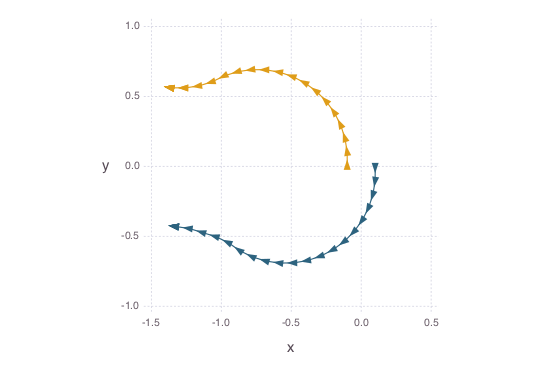

In [12]:
## Code for plotting Dubins vehicle state with triangle to show orientation

triangles_v1 = Array(Any, N+1)
triangles_v2 = Array(Any, N+1)
for k=1:N+1
    triangles_v1[k] = Guide.annotation(marker(x_opt[1, k], x_opt[2, k], x_opt[3, k], berkeley_gold, 0.05))
    triangles_v2[k] = Guide.annotation(marker(x_opt[4, k], x_opt[5, k], x_opt[6, k], berkeley_blue, 0.05))
end

p = Gadfly.plot(layer(x=x_opt[1, :], y=x_opt[2, :], Geom.path, Theme(default_color=berkeley_gold)),
  layer(x=x_opt[4, :], y=x_opt[5, :], Geom.path, Theme(default_color=berkeley_blue)),
  triangles_v1...,
  triangles_v2...,
  Coord.cartesian(fixed=true)
)
draw(PDF("Dubins_cooperative_state_deterministic.pdf", 10cm, 20cm), p)
p

In [13]:
function evaluate_cost(x, u, theta, g, g_terminal, N)
    return g_terminal(x[:, N+1]) + sum([g(k, x[:, k], u[:, k], theta)] for k=1:N)
end
    
C = evaluate_cost(x_opt, u_opt, theta0, g, g_terminal, N)
# C_prime = evaluate_cost(x0*ones(N+1)', zeros(size(u_opt)), theta0, g, g_terminal, N)

1-element Array{Float64,1}:
 -0.00840607

In [14]:
using Plots
gr()

Plots.GRBackend()

In [15]:
# plot value function 

# J = max(J, -1000)

Plots.plot(layout=grid(5, 5), size=(2400, 1200), 
[contour(Array(xgrid_reduced[2]), Array(xgrid_reduced[1]), J[:, :, k, N-j], fill=true, legend=true) 
    for k=1:10:50, j=0:2:8]...
)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -1.5 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 -1.5 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
<image width="196" height="221" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAMQAAADdCAYAAADkf904AAAgAElEQVR4nOy925bjOJIsau4AIyP3
rv1w/v8nz1m7ZyorRLifB7/AAVKKyOrq7uyZQS4lReoSkginmfkNBDQFAEIHiMH0DhCh83cQGjp/
R+c3MI7cHviG5tuOjkMPvOmBhoYDDZ0YBxoaEQ4mMICDGJ2BRsDBBAJw+H4cb6Q4GGAoOgNMioMU
TEBnBUNxsKKRgknRfdtIQaToJGACGgkOFhApGgsYviWgsYBgr2MWez0LAKDxyNcAAPt7xA2wz0T7
jevj9lpi2weQj+337/brUKWn+8t9IYhyHlch25ab+DaeI8LL8SFt25+PD2U/NvdFCadw3h/lptv+
QxiiwEMYCuAhBPGtKvBQwinw58KfAwwFHqK5f4rihPoxxUMFJwQPHbalBx74wEkDD/yBgUduT/2A
6IlT/8Apv0NVcMp/QiFQ+cO2+gF+ejb+Z/zP+G84OsImiEFggAgEBqGBiO0W98HXf2pH838i38Ju
ABgEin0CCPN+7NtV29DBnqv22nh+PO6oYO8xr9Kc76l53N7Dt2RX40AHKs+Lq/SOBnWfb45VdNiR
4RkqXBDC0eh2yBevVwyw2PsI2H50uTxlOZSI5seZBALO/fq4Qv1YPN9+byIFqf22onaeFYCQgpT8
vMa5JTApRH0uqL8XAaR27hTI96JyXHybryPY+/hMzZvafGUoGA0CsbkL2Z8JEEDUAAUUDIJtO9Ob
/0AdAKPRNxAxGr+B6UCnbzj4/SlV6tpxoN9SpQ5CZzOO7lTJKBMKZdKNMtmPfbD6c4zqHCy5HxTp
8G1SKB5gGC06kv4ErZoUKravKNIrasQkeX8+JstEe0qZNgP4KcpUDGSnTEmHnOrkzenUZ1RKyuvE
94c0iBLYHxvEUBCaqE/ahkEKVUIjwlDFKQQFYZAaZRIGE+UEVhDYqRcRoG4YQ4FT4ROTwAIMgj8X
YFUQjIKxKIQUrGz7IDSIXZyVcGLYMepgMAY6mBiDHm79gOgJJYHSMHNXm3cTIcAgMiRgOsB02FWf
+ktkSJu7QYZAhUCE5lbeKPZXY2jxGEIXwCe7bQnxvDkxQzOElojJ3ziMRS56wYxg5H0uBvFnDCGe
sxrEnPirQfwdGqI8dzEI4mkQPkHTMIhAqmYYdDUM2rRFHMvPV7RJbhn+OgHYj4ljC5teyMECFb8C
s13txeeBis1PCaiAQpkgqhCyvxfPHcMQRmNeKYGhEKxIQWAznidIwdTBeADoYOqOPgcED0AZ3ZDB
rD0MgamjUQehoVF3qTxvXRsaum8bGhgdjAZGI9pu8IlMxRDgQnk1hu5COZCCXERXAd0DIaCOHtNA
Dh4+6R0tnhhC0qnNIC4G0uSlEcQEf4UQu4G8MoDPxo4CedyNwO6HIej6fCawShrEkLYYBoBEi9g3
iiNgYogyyN+TZL533CdSkLAZnzp9EbtogiWNxoyaMRRQAggmsMFmKQKbL0IKgCB+cR1OqcxInJo5
nigIUIaQoqs9q6MDCojPb8Xw32dA9ACRQOhcHhNSdOY3//IdTAcafXOD+IZGHR3f8Ib/hY4DB97Q
tOFN39DQ8IaG5jTpIDZaRGYUdx6lb82+7LcWdGgaQhhFUKI7Q2DADULmsYICvc393iYdYpI0jGoE
XzEA9vepE39HhN1AECcYAL3QFj875gQnqBZ9ITbJ4zmJDtsxGfYaGQ1Nx0KrdgMxysQLnRq5NSpF
QxcaNUhwpkdKk0aRvy4NCuZRqhRqKOEkgMRplL/W6Jb/pEIYappEAZCwvb8qmipYjKk0NfrU0Zwy
GfNpePgbAUNPKA8MZUAAQgMY6OwWFMhgxnA4/3JEMIWApg0dHYYPjEaGDJ0InTBRIa/8tNAkQwst
tGg1huYu1V5cq80NIVDB6JCkVlhcqoUe7YhQJ38aShxrjhAx+QsScJOLIeyIQKyfGkBSKP7zBkEx
wYmhWugTEcCcz0naRMUVuxniTqsALJQqhlSqVPZJC01zGmXk3AiKKWajUUIEgaKBU3QDK4Wa38X2
zUdAJtBhcymeZwihvm+uW8Tr1ARq/D5dTZh0BHI8oDjs+Wpb9XOmGOiNvgGYBtEdIXoR0K+QoRPh
ILpFhl1Ap1B2fXCwIUCNMQRCVESo9KizpCEcPlknQszJ39t5QYRlv7mo5npsXJCAm6yowApyFAEm
QuATA0hkeOVV+mxI4fNlFi0USu4Qgo2OFIRINAgUGGwoEigwmh27QYjYZ5JFeDdiDPa4hAgGWZwi
kIElPEjq4tiey2SxiviJxFiV/VRsCBHmzPkcczmxR9GciQFi+haE1EIcWxCU3u18oEFZDCEYiRSd
6bAnOzKEflh0wwtkWPTChgwpkotOsCu6K3pHh55X//UWyLAghXuQTIOsOqG3kfQojOPOEIgUrY3F
EABcJn81kmoIFSFQ9+vkr6K6epx2hKAXBlJpEQB17kDAvIoL22co6BH7EyEUSrQEnW61hn8PFZvE
Etph6EJ5RnlNTnb3OE190cwVPQrnJwET5fdQv/ovqLHpCpGpIXahrS7EK1JoaI8nSNEwILA5Pxwp
VCWRopP/aBxxBo87XL1KxaPkyt40vVneM2NYBXRM8ulJyslPV4MIilQ9SN09SKtQDuFcdEN5LKkS
64IKoQ/CEG7p0YYaeGIQYQCJHDHx98j1T1GmzUUbk14IxJzP0aIhgq8HUgATUSQ/QwNEFpSIiS2j
LfSKfEIt9AhTgMf95VMroTkVEzXxq2qTXJVyYqtTUxVOg6geqBDVCpszu9BWN4Thrx1uTAwFq+mT
NVYR/8zzFH4oIgap6YzekzL1FNFGld7RtrSMb9TBIHwjjzU4MhxMeGMkZeo00zJmPEHxjY0qfWMx
ykSCzqtwtlQNWSgSk2Zc4WiCnvfDAGxbUaHXye6IMA3DJv+dQVyQoI+LMYBlnfhBoZ4gRDWCi6h+
ZSCyTrS8KtfHigEAftVUXowknkOnOw/GWGiVKoPPoE5mKDIkKRO7l0jYECOPky40ikXQxJ6TQTi0
EmxriTRD2MWxXVRDaEfMgmFGxR5Wszm6Cm17jRtOFd6w83xqAwCcMKsiZYgpaDebYWKagOH4maK6
imjPSELfqFJgRyBD89hDc8skIL+c3cwYOkWMYcYUIj9pRwh2I7kK5xlX+LJg3hChUiBuI40ltUN5
DACoSRpEGMFiAD6h0wAWgygT/S8yCNQrcU52mUoUgRBilCmeEwaSYpYhoyWtUvVIdKVd8SeL6xZY
EeMZQoTrNWIcCsq4hcARggXqE1lJISxmuAi3a3xNn7q8Cm14zCvQA741lJhI0Zx2iquQoT2NYjh1
CpGtEPRglnfBNypUiZJITY9SUCXyDxO0KeiRoYWhQqZPIIJ1moYTwbDwMFFJDQgvUiblbe5S3gwh
j7sLdZn0GxqkS7ULKJ7LAnKvE/UxKdOGBItITqPYjCTGYhzrHL9oijJ0kxdUI15BO5hsIue+6wli
+6GBmQtRhlGOXX+QH78GANOYquvX3582gzBjGemJstewn0873/aeFlYTAlgbwIIxms8V8lQOdcTw
z+xpIKYd7O+eBDSYMbSiJ0DAiNeTfY6gTqoCpmt6

In [16]:
# save value function computed at grid points 
# using HDF5, JLD
# save("J_Dubins_cooperative.jld", "data", J)